In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('online_retail_II.csv', encoding='ISO-8859-1')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


# Data Cleaning

In [4]:
# Remove missing customer id
df = df.dropna(subset=['Customer ID'])

In [5]:
# Remove cancelled Transaction
df = df[~df['Invoice'].str.startswith('C')]

In [6]:
# remove negative or 0 quantity
df = df[df['Quantity'] > 0]

In [9]:
# Convert invoicedate to datetime
df['InvoiceDate'] = pd.to_datetime(
    df['InvoiceDate'],
    format='%d/%m/%Y %H:%M',
    errors='coerce'
)

In [11]:
# create total amount
df['TotalAmount'] = df['Quantity'] * df['Price']

In [12]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [13]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalAmount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


# RFM Scores


In [14]:
# recency
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])

In [15]:
# frequency
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])

In [16]:
# monetary
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

In [18]:
# rfm score
rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].astype(str).sum(axis=1)

In [19]:
# customer segments
def segment_customer(row):
    if row['RFM_Score'] in ['444', '443', '434', '344']:
        return 'Champions'
    elif row['F_score'] == '4':
        return 'Loyal Customers'
    elif row['R_score'] == '4':
        return 'Recent Customers'
    elif row['R_score'] == '1':
        return 'At Risk'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

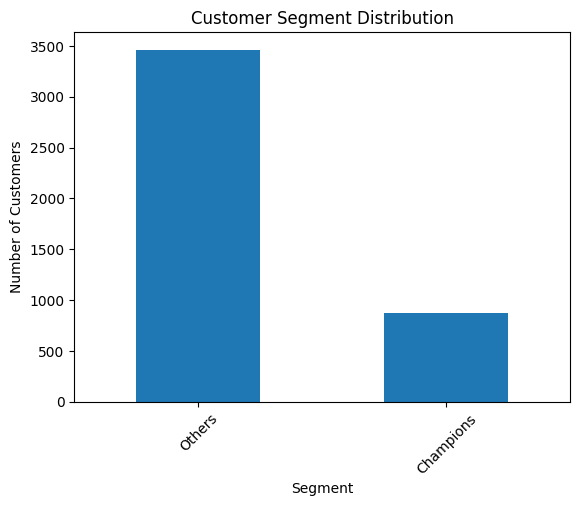

In [20]:
rfm['Segment'].value_counts().plot(kind='bar')
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

In [21]:
rfm.to_csv('rfm_segments.csv')